<a href="https://colab.research.google.com/github/carlosmvond/modelos_predictivos/blob/main/Clase_5_nov_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este ejemplo vamos a ver como tratar modelos cuando sospechemos que existen outliers.

Para esto vamos a considerar una regresion lineal de la forma

$$y_i=\alpha x_i+\beta_i+\epsilon_i.$$

Vamos a evaluar dos alternativas:

* $\epsilon_i \sim N(0, \sigma)$
* $\epsilon_i \sim t(\nu, 0, \sigma)$


Comenzamos creando un conjunto de datos artificial. El gráfico muestra los outliers en rojo.


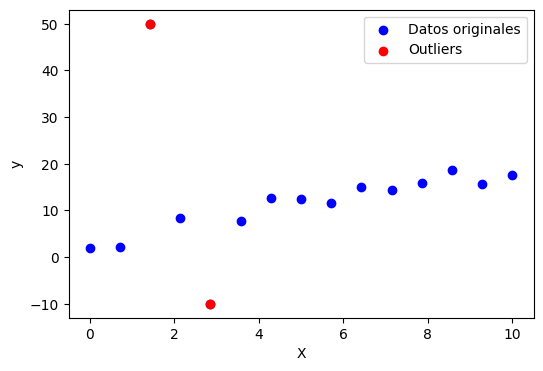

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import pymc as pm
import arviz as az
from sklearn.linear_model import LinearRegression

# 1. Generar datos a partir de una regresión lineal y agregar error
np.random.seed(42)
X = np.linspace(0, 10, 15)
alpha_original = 1.0  # Intercepto
beta_original = 2.0   # Pendiente
sigma_original = 2.0  # Desviación estándar del error

# Generar la relación lineal
y = alpha_original + beta_original * X + np.random.normal(0, sigma_original, size=X.shape)

# Agregar outliers a los datos
outliers_x = [2, 4]  # Indices donde se introducirán outliers
outliers_y = [50, -10]  # Valores de los outliers
y[outliers_x] = outliers_y  # Introducir los outliers en los datos

# Crear un gráfico de dispersión
plt.figure(figsize=(6, 4))

# Graficar los puntos originales sin los outliers
plt.scatter(X, y, color='blue', label='Datos originales')

# Resaltar los outliers en un color distinto
plt.scatter(X[outliers_x], y[outliers_x], color='red', label='Outliers')

# Añadir etiquetas y título
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

# Mostrar el gráfico
plt.show()



Ahora ajustamos el modelo utilizando PyMC y usando una regresión lineal clásica.

Output()

<ipython-input-39-009e617a764a>:45: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=0.95)  # 95% credible intervals


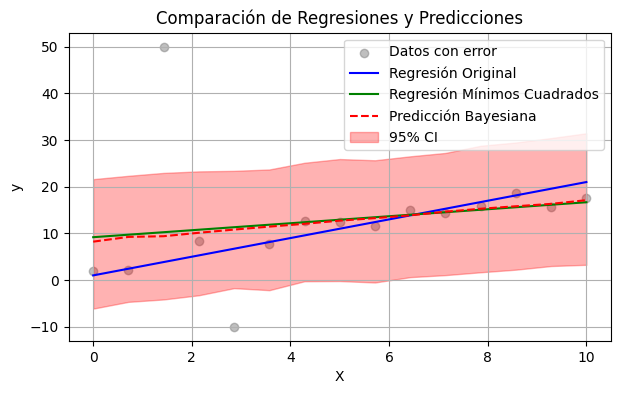

In [39]:

# 2. Ajustar una regresión lineal usando PyMC
from scipy.stats import t

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
    #nu = pm.Uniform('nu', lower=2.01, upper=100)

    mu = alpha + beta * X
    # Usar la distribución Student's t para las observaciones
    #y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma, nu=3, observed=y)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    trace = pm.sample(2000, tune=1000, cores=2, return_inferencedata=True)


# 3. Ajustar una regresión lineal usando mínimos cuadrados
lr = LinearRegression()
lr.fit(X.reshape(-1, 1), y)
alpha_mle = lr.intercept_
beta_mle = lr.coef_[0]

# 4. Crear gráficos

# HDI (Intervalo de Densidad Alta) para la regresión bayesiana
alpha_samples = trace.posterior['alpha'].values.flatten()
beta_samples = trace.posterior['beta'].values.flatten()
#nu_samples = trace.posterior['nu'].values.flatten()
sigma_samples = trace.posterior['sigma'].values.flatten()



y_pred_samples = np.empty((len(alpha_samples), len(X)))

for i in range(len(alpha_samples)):
    # Calcular el parámetro de ubicación (loc) para la muestra actual
    loc = alpha_samples[i] + beta_samples[i] * X
    # Generar predicciones usando la distribución t de Student
    y_pred_samples[i] = np.random.normal(loc=loc, scale=sigma_samples[i], size=len(X))# t.rvs(df=3, loc=loc, scale=sigma_samples[i], size=len(X))


# 5. Calculate the mean and credible intervals for predictions
y_pred_mean = y_pred_samples.mean(axis=0)  # Mean of predicted samples
y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=0.95)  # 95% credible intervals

# Plotting the results
plt.figure(figsize=(7, 4))

# Plot original data with outliers
plt.scatter(X, y, label='Datos con error', color='gray', alpha=0.5)

# Original regression line
plt.plot(X, alpha_original + beta_original * X, label='Regresión Original', color='blue')

# MLE regression line
plt.plot(X, alpha_mle + beta_mle * X, label='Regresión Mínimos Cuadrados', color='green')

# Bayesian regression line (mean prediction)
plt.plot(X, y_pred_mean, label='Predicción Bayesiana', color='red', linestyle='--')

# Credible intervals for the Bayesian predictions
plt.fill_between(X, y_pred_hdi[:, 0], y_pred_hdi[:, 1], color='red', alpha=0.3, label='95% CI')

# Details for the plot
plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparación de Regresiones y Predicciones')
plt.legend()
plt.grid()

plt.show()

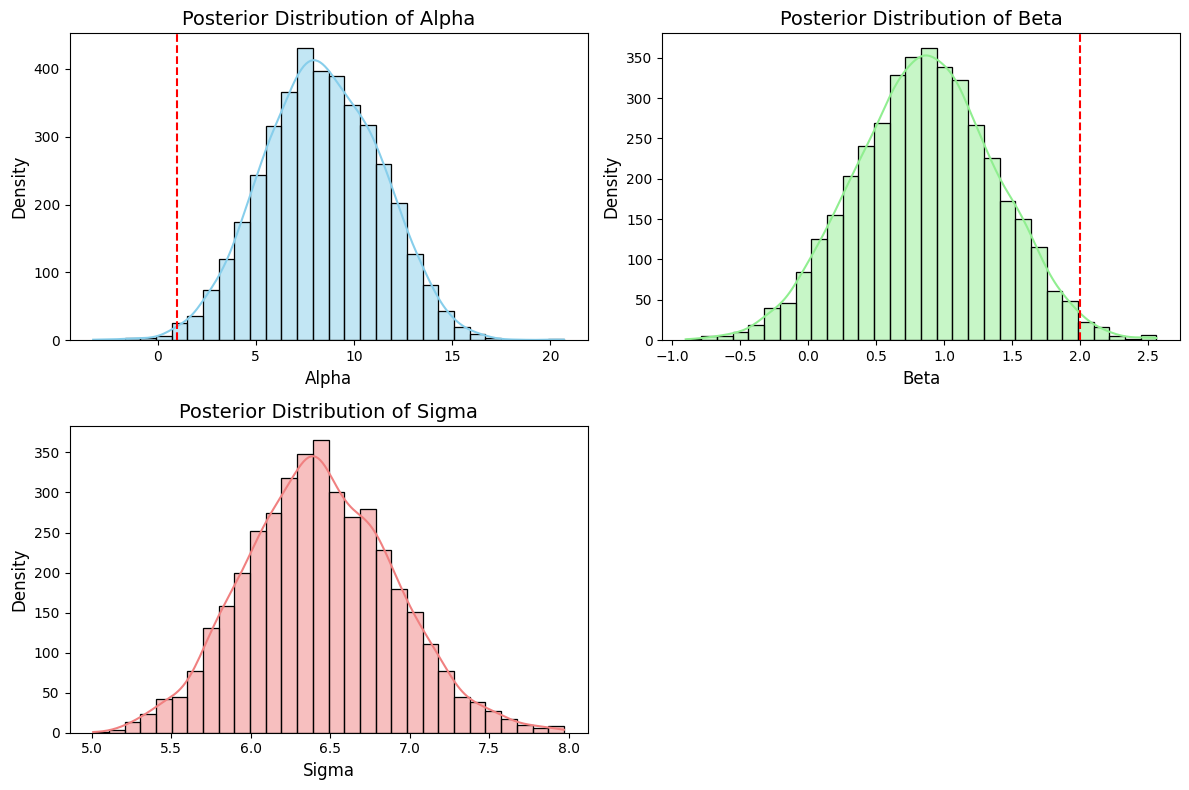

In [40]:
import seaborn as sns
# Create a figure for the histograms
plt.figure(figsize=(12, 8))

# Plot histogram for 'alpha'
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.histplot(alpha_samples, kde=True, color='skyblue', bins=30)
plt.axvline(alpha_original, color='red', linestyle='--')
plt.title('Posterior Distribution of Alpha', fontsize=14)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Plot histogram for 'beta'
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
sns.histplot(beta_samples, kde=True, color='lightgreen', bins=30)
plt.axvline(beta_original, color='red', linestyle='--')
plt.title('Posterior Distribution of Beta', fontsize=14)
plt.xlabel('Beta', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Plot histogram for 'sigma'
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, 3rd subplot
sns.histplot(sigma_samples, kde=True, color='lightcoral', bins=30)
plt.title('Posterior Distribution of Sigma', fontsize=14)
plt.xlabel('Sigma', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Optional: Plot histogram for 'nu' (if you have `nu_samples`)
# plt.subplot(2, 2, 4)  # 2 rows, 2 columns, 4th subplot
# sns.histplot(nu_samples, kde=True, color='lightyellow', bins=30)
# plt.title('Posterior Distribution of Nu', fontsize=14)
# plt.xlabel('Nu', fontsize=12)
# plt.ylabel('Density', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()